<a href="https://colab.research.google.com/github/13693763686/data-analysis/blob/master/scikit-learn%20notebooks/card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 案例：用逻辑回归制作评分卡

In [ ]:
##通过这个案例的学习，对机器学习建模整体的过程有一个更清晰的认识，更好地理解数据预处理的知识，将理论和实践相结合
##机器学习模型的搭建通常需要六个步骤
##获取数据 -- 爬虫，业务等等
##数据清洗，特征工程 -- 将数据处理成便于处理的格式
##模型开发 -- 选择合适的模型，进一步根据模型的需求调整数据
##模型验证和调试 --- 很重要的一步，通过不停的调试获取优秀的工业级结果
##模型上线 --- 工业化使用，倾听反馈
##监测与报告 --- 收集数据，产品迭代
##下面就对这个案例进行分析建模

## 数据清洗

### 导入必需的库

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LogisticRegression as LR

In [ ]:
#读入数据
data = pd.read_csv("rankingcard.csv",index_col=0)

###探索数据

#### 观察数据的特征和空值情况

In [ ]:
data.shape
#观察到整个数据集有11个feature，并不是特别的多，如果很多的话考虑特征工程进行过滤
#基于列本身的信息，相关关系或者PCA聚类都可以

(150000, 11)

In [ ]:
data.info()
#注意到有两列存在空值，且这两个列的数据极为重要，因此这里我们需要非常仔细地处理}

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [ ]:
data.describe().T
#观察到量纲严重不符合，对于某些模型的话需要处理
#观察到年龄里面的最大值存在109岁的情况，需要我们进行一些异常值侦测和处理的过程
#大部分特征都存在偏态的分布，中心化处理的必要性，这个通过观察均值和中位数，中位数大于平均数的话，表明数据在左侧以细长的姿态拉低了均值，即左偏分布
#从这些观察可以看出问题很多，但是首要问题还是空值和异常值的问题
#下面首先处理重复值，然后是空值和异常值

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [ ]:
hand_bins

{'NumberOfDependents': [-inf, 1, 2, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 1, 2, 4, inf]}

####去除重复值

In [ ]:
#对于数据集的重复值，当处于不失衡的状态下，不应该有重复值的情况，这很有可能是重复地录入
#当然也有可能是某些情况地频繁出现，这种情况可以反应标签比例，但一般情况下并不是如此
data.drop_duplicates(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149391 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

In [ ]:
data.index = range(data.shape[0])

In [ ]:
data.index

RangeIndex(start=0, stop=149391, step=1)

#### 缺失值的处理

In [ ]:
#首先处理缺失值的话，可以在排除掉某些特征的时候减轻异常值处理的困难，毕竟缺失值一般肯定比异常值要多
#对于月收入这种重要因素，我们必须使用精细的学习方法，对于亲属个数来说，缺失值不是特别多，可以直接删除，或者均值或者众数补充
#这里我们使用均值来填补亲属个数
data["NumberOfDependents"].fillna(int(data["NumberOfDependents"].mean()),inplace=True)

In [ ]:
#当处理完亲属个数的时候，我们只剩下月收入需要处理了，我们可以利用随机森林进行插值的处理
#随机森林插值相对其它的监督学习方法来讲，更为简单，模型调参的情况可以只调树的个数，而对其它的模型来讲，可能需要调很多参数
#因此，对于我们的插值来说，我们不希望在最开始的时候就弄的特别复杂
#这里我们选择使用随机森林插值的方法
#下面写一个通用的函数，处理单插值的问题，注意数据和标签在一个dataframe里面

In [ ]:
def fill_missing_rf(X,y,to_fill):
  """
  使用随机森林填补缺失一个特征值的数据矩阵
  参数：
  X：要填补的特征矩阵
  y：标签向量
  to_fill：填补的特征向量的字符串名字
  返回值：
  返回空值对应的插值结果，维度与y不一致
  """
  df = X.copy()
  fill = df.loc[:,to_fill]
  df = pd.concat([df.loc[:,df.columns!=to_fill],pd.DataFrame(y)],axis=1)
  Ytrain = fill[fill.notnull()]
  Ytest = fill[fill.isnull()]
  Xtrain = df.iloc[Ytrain.index,:]
  Xtest = df.iloc[Ytest.index,:]
  from sklearn.ensemble import RandomForestRegressor as rfr
  rf = rfr(n_estimators=100)
  rf = rf.fit(Xtrain,Ytrain)
  Ypredict = rf.predict(Xtest)
  return Ypredict

In [ ]:
#接下来利用上面的插值函数对我们的数据进行处理
#准备数据，X为特征矩阵，不包括标签
X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]

In [ ]:
y_pred = fill_missing_rf(X,y,"MonthlyIncome")

In [ ]:
y_pred[:5]
pd.DataFrame(y_pred).describe()
#其实这个结果是有一点奇怪的，因为income的值怎么会是75%分位上面还是0.53的值的，因此，这个插值结果可能有问题
#这里显然感觉是有问题的，这些数据对模型的影响会很大，尽管它们占整体的比例毕竟高，但是还是建议删除比较好

,0
count,29221.000000
mean,286.428431
std,3404.338392
min,0.000000
25%,0.060000
50%,0.210000
75%,0.530000
max,391829.678333


In [ ]:
#确认数据无误后，注意y_pred的值只是关于空值的部分，因此我们还是需要做一些筛选的工作
#尽管数据可能存在一定的问题，这里我们不再深究，可能其中有一定的道理吧
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

In [ ]:
y[:5]

0    1
1    0
2    0
3    0
4    0
Name: SeriousDlqin2yrs, dtype: int64

#### 寻找数据中的异常值

In [ ]:
data.describe([0.01,0.1,0.25,0.5,0.75,0.9,0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
SeriousDlqin2yrs,149391.0,0.066999,0.250021,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,149391.0,6.071087,250.263672,0.0,0.0,0.003199,0.030132,0.154235,0.556494,0.978007,1.093922,50708.0
age,149391.0,52.306237,14.725962,0.0,24.0,33.000000,41.000000,52.000000,63.000000,72.000000,87.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,149391.0,0.393886,3.852953,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,98.0
DebtRatio,149391.0,354.436740,2041.843455,0.0,0.0,0.034991,0.177441,0.368234,0.875279,1275.000000,4985.100000,329664.0
MonthlyIncome,149391.0,5425.469300,13238.107209,0.0,0.0,0.180000,1800.000000,4416.000000,7416.000000,10800.000000,23250.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,149391.0,8.480892,5.136515,0.0,0.0,3.000000,5.000000,8.000000,11.000000,15.000000,24.000000,58.0
NumberOfTimes90DaysLate,149391.0,0.238120,3.826165,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,98.0
NumberRealEstateLoansOrLines,149391.0,1.022391,1.130196,0.0,0.0,0.000000,0.000000,1.000000,2.000000,2.000000,4.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,149391.0,0.212503,3.810523,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,98.0


In [ ]:
data = data[data["age"]!=0]

In [ ]:
data = data[data.loc[:,"NumberOfTimes90DaysLate"] < 90]

In [ ]:
data.index = range(data.shape[0])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149165 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149165 non-null  float64
 2   age                                   149165 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149165 non-null  int64  
 4   DebtRatio                             149165 non-null  float64
 5   MonthlyIncome                         149165 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149165 non-null  int64  
 7   NumberOfTimes90DaysLate               149165 non-null  int64  
 8   NumberRealEstateLoansOrLines          149165 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149165 non-null  int64  
 10  NumberOfDependents                    149165 non-null  float64
dtype

In [ ]:
#以上缺失值和异常值处理完毕，但是量纲统一和标准化的工作还没有做
#正常来说，有些算法非常依赖于数据的分布，在正态分布下它们的效果会好很多
#这里我们的考虑主要还是客户，因为我们会在下一步进行分箱的操作，这时候如果进行量纲化的话，对于业务人员来说是一个比较飘渺的东西
#因此，从业务应用的角度，我们建议不进行量纲化的处理

In [ ]:
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### 样本不均衡的问题

In [ ]:
#样本不均衡是比较严重的问题，对于异常检查的算法来讲，因为过少的数据会使模型的训练会朝着数据较多的一方偏斜，导致错误。
#但是通常来说，我们特别需要对异常情况的检测，因为它的一个小错误可能会造成很坏的结果，通常我们会调节权重
#对于存在loss函数的算法来讲，只需要在其出错的时候对其放大一定的权重即可，但是为了模型的普遍性，通常我们会手动的添加样本来作为平衡
#手动的方法是通过采样的方式
import imblearn
from imblearn.over_sampling import SMOTE
X = data.iloc[:,1:]
y = data.iloc[:,0]
sm = SMOTE(random_state=100)
X,y = sm.fit_sample(X,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#此时来检验标签的平衡情况,可以发现标签数已经平衡了
#注意y是一个ndarray
pd.Series(y).value_counts()

1    139292
0    139292
dtype: int64

####分离测试集和训练集

In [ ]:
from sklearn.model_selection import train_test_split
X = pd.DataFrame(X)
y = pd.DataFrame(y)
x_train,x_vali,y_train,y_vali = train_test_split(X,y,test_size=0.3,random_state=100)

In [ ]:
##下面把训练集的特征矩阵和标签矩阵放到一起
model_data = pd.concat([y_train,x_train],axis=1)
model_data.index = range(model_data.shape[0])

In [ ]:
model_data.columns = data.columns

In [ ]:
model_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.240829,56.000000,0.000000,0.215378,10000.0,19.000000,0.0,0.000000,0.000000,0.000000
1,1,0.655020,48.908972,0.318162,0.957567,4000.0,17.908972,0.0,1.363676,0.318162,0.000000
2,0,0.487529,46.000000,0.000000,0.115788,5630.0,10.000000,0.0,0.000000,0.000000,0.000000
3,0,0.411973,61.000000,0.000000,0.142112,2300.0,3.000000,0.0,0.000000,0.000000,0.000000
4,1,0.845843,50.302671,2.513357,0.127204,9600.0,12.000000,0.0,0.302671,0.000000,0.605343


In [ ]:
vali_data = pd.concat([y_vali, x_vali], axis=1)#验证集
vali_data.index = range(vali_data.shape[0])
vali_data.columns = data.columns

##模型开发-分箱--关键操作

In [ ]:
#特征工程由于这里的特征太少，并没有进行专门的操作，因此省略掉，对于此问题，模型的构造较为重要，因此这里我们注意考虑分箱操作
#对于评分卡来说，每一个箱子所处的等级就是打分的依据，因此是整体的核心
#这里的分箱的分界点必须仔细地选取，否则结果很差
#箱子的数量也不能太多或者太少，要分出有效果的箱子
#要想正确的分箱，必须对业务有一定的了解，下面套用IV的知识

###卡方检验选择箱数

In [ ]:
model_data["qcut"], updown = pd.qcut(model_data["age"], retbins=True, q=20)

In [ ]:
model_data["qcut"]

0           (54.0, 56.0]
1         (48.443, 50.0]
2         (45.0, 46.973]
3          (58.75, 61.0]
4           (50.0, 52.0]
               ...      
195003      (39.0, 41.0]
195004     (58.75, 61.0]
195005     (58.75, 61.0]
195006     (56.0, 58.75]
195007      (50.0, 52.0]
Name: qcut, Length: 195008, dtype: category
Categories (20, interval[float64]): [(20.999, 28.0] < (28.0, 31.099] < (31.099, 34.0] <
                                     (34.0, 36.605] ... (61.0, 64.0] < (64.0, 68.0] < (68.0, 74.0] <
                                     (74.0, 109.0]]

In [ ]:
coount_y0 = model_data[model_data["SeriousDlqin2yrs"] == 0].groupby(by="qcut").count()["SeriousDlqin2yrs"]
coount_y1 = model_data[model_data["SeriousDlqin2yrs"] == 1].groupby(by="qcut").count()["SeriousDlqin2yrs"]

In [ ]:
num_bins = [*zip(updown,updown[1:],coount_y0,coount_y1)]

In [ ]:
for i in range(20):
    #如果第一个组没有包含正样本或负样本，向后合并
    #注意我们的num_bins是一个列表，是可变的结构，可以在操作过程中慢慢地改变
    #对于dataframe来讲，这是不能改变的，不能在中间截断似地赋值
    if 0 in num_bins[0][2:]:
        num_bins[0:2] = [(
            num_bins[0][0],
            num_bins[1][1],
            num_bins[0][2]+num_bins[1][2],
            num_bins[0][3]+num_bins[1][3])]
        #如果发生合并地话，向下面不断地传播，直到找到存在满足条件的样本
        continue
    #这里我们也可以同时的自下像上合并，与上面同样的逻辑
    for i in range(len(num_bins)):
        if 0 in num_bins[i][2:]:
            num_bins[i-1:i+1] = [(
                num_bins[i-1][0],
                num_bins[i][1],
                num_bins[i-1][2]+num_bins[i][2],
                num_bins[i-1][3]+num_bins[i][3])]
        break

In [ ]:
#下面的工作就是计算woe和iv的值
def get_woe(num_bins):
    columns = ["min","max","count_0","count_1"]
    #利用我们的矩阵构造一个dataframe
    #前两个表示上下限，后面两个表示箱内的0和1的个数
    df = pd.DataFrame(num_bins,columns=columns)
    df["total"] = df.count_0 + df.count_1#一个箱子当中所有的样本数
    df["percentage"] = df.total / df.total.sum()#一个箱子里的样本数，占所有样本的比例
    df["bad_rate"] = df.count_1 / df.total#一个箱子坏样本的数量占一个箱子里边所有样本数的比例
    df["good%"] = df.count_0/df.count_0.sum()
    df["bad%"] = df.count_1/df.count_1.sum()
    df["woe"] = np.log(df["good%"] / df["bad%"])
    return df
 
#计算IV值
def get_iv(df):
    rate = df["good%"] - df["bad%"]
    iv = np.sum(rate * df.woe)
    return iv

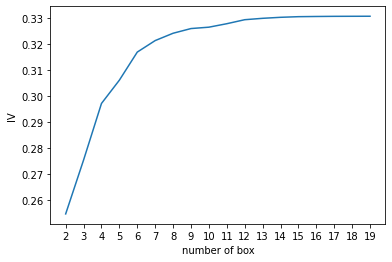

In [ ]:
num_bins_ = num_bins.copy()
 
import matplotlib.pyplot as plt
import scipy
 
IV = []
axisx = []
 
while len(num_bins_) > 2:#大于设置的最低分箱个数
    pvs = []
    #获取 num_bins_两两之间的卡方检验的置信度（或卡方值）
    for i in range(len(num_bins_)-1):
        x1 = num_bins_[i][2:]
        x2 = num_bins_[i+1][2:]
        # 0 返回 chi2 值，1 返回 p 值。
        pv = scipy.stats.chi2_contingency([x1,x2])[1]#p值
        # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]#计算卡方值
        pvs.append(pv)
        
    # 通过 p 值进行处理。合并 p 值最大的两组
    i = pvs.index(max(pvs))
    num_bins_[i:i+2] = [(
            num_bins_[i][0],
            num_bins_[i+1][1],
            num_bins_[i][2]+num_bins_[i+1][2],
            num_bins_[i][3]+num_bins_[i+1][3])]
    
    bins_df = get_woe(num_bins_)
    axisx.append(len(num_bins_))
    IV.append(get_iv(bins_df))
    
plt.figure()
plt.plot(axisx,IV)
plt.xticks(axisx)
plt.xlabel("number of box")
plt.ylabel("IV")
plt.show()
#选择转折点处，也就是下坠最快的折线点，所以这里对于age来说选择箱数为6

In [ ]:
def get_bin(num_bins_,n):
  """
  利用卡方检验的方法把箱子的数量减少到n个
  """
  while len(num_bins_) > n:
      pvs = []
      for i in range(len(num_bins_)-1):
          x1 = num_bins_[i][2:]
          x2 = num_bins_[i+1][2:]
          pv = scipy.stats.chi2_contingency([x1,x2])[1]
          # chi2 = scipy.stats.chi2_contingency([x1,x2])[0]
          pvs.append(pv)

      i = pvs.index(max(pvs))
      num_bins_[i:i+2] = [(
              num_bins_[i][0],
              num_bins_[i+1][1],
              num_bins_[i][2]+num_bins_[i+1][2],
              num_bins_[i][3]+num_bins_[i+1][3])]
  return num_bins_

In [ ]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''
    #可以观察到此函数把之前所有的操作打包成一个函数，构成一个分箱函数
    DF = DF[[X,Y]].copy()

    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break

    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["good%"] / df["bad%"])
        return df

    def get_iv(df):
        rate = df["good%"] - df["bad%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]

        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
        
    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df

RevolvingUtilizationOfUnsecuredLines


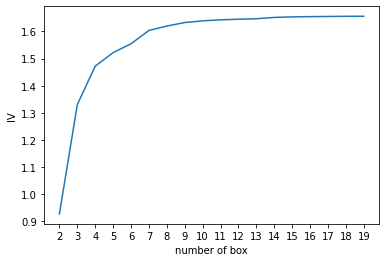

age


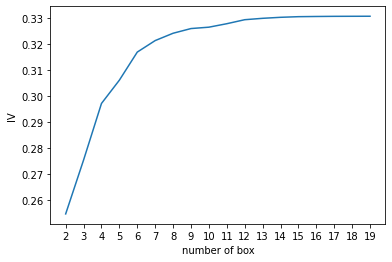

NumberOfTime30-59DaysPastDueNotWorse


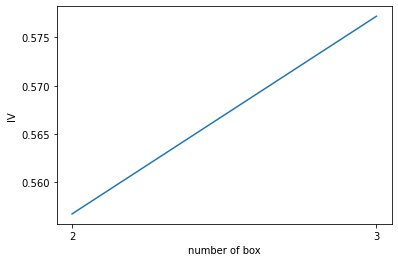

DebtRatio


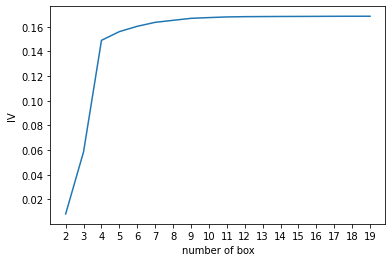

MonthlyIncome


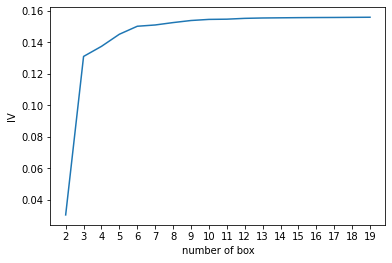

NumberOfOpenCreditLinesAndLoans


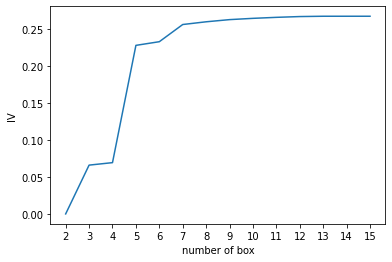

NumberOfTimes90DaysLate


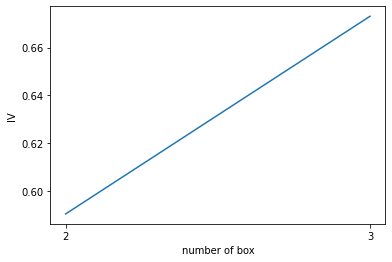

NumberRealEstateLoansOrLines


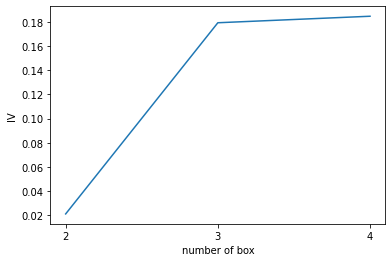

NumberOfTime60-89DaysPastDueNotWorse


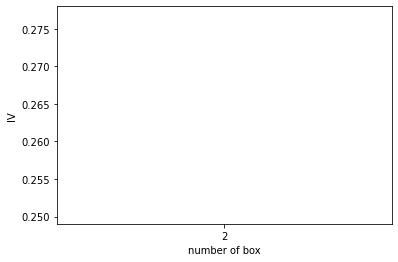

NumberOfDependents


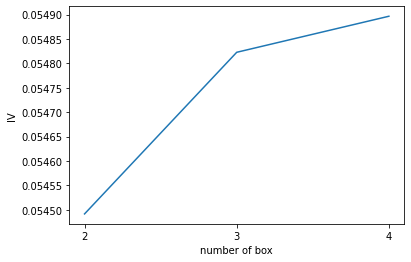

In [ ]:
for i in model_data.columns[1:-1]:
    print(i)
    #标签所属的列是恒定的列，n=2的目的是为了看出整体的趋势，20是最初的分箱数
    graphforbestbin(model_data,i,"SeriousDlqin2yrs",n=2,q=20)

In [ ]:
#注意对于某些特征，本身属于分类变量，它的最大分箱数也不可能达到20，因此我们的自动分箱没有任何作用
#对于这种情况，我们可以单独指定其分箱的方式，即指定表示上下限的列表
#对于可以自动装箱的特征，列出其参数列表
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":6,
                "age":5,
                "DebtRatio":4,
                "MonthlyIncome":3,
                "NumberOfOpenCreditLinesAndLoans":5}
#对于不能自动装箱的特征，列出其分箱的方式
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
            ,"NumberOfTimes90DaysLate":[0,1,2,17]
            ,"NumberRealEstateLoansOrLines":[0,1,2,4,54]
            ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8]
            ,"NumberOfDependents":[0,1,2,3]}

In [ ]:
bins_of_col = {}
 
#生成自动分箱的分箱区间和分箱后的 IV 值
for col in auto_col_bins:
    bins_df = graphforbestbin(model_data,col
                  ,"SeriousDlqin2yrs"
                  ,n=auto_col_bins[col]
                  ,q=20
                  ,graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list
    
#利用字典的update方法直接对其更新
#这里同样也要注意对hand_bins的区间进行处理
for key,val in hand_bins.items():
  val[0],val[-1] = -np.inf,np.inf
hand_bins

{'NumberOfDependents': [-inf, 1, 2, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 1, 2, 4, inf]}

In [ ]:

bins_of_col.update(hand_bins)
bins_of_col

{'DebtRatio': [-inf,
  0.017930832394402144,
  0.5025616147087272,
  1.4196358925942234,
  inf],
 'MonthlyIncome': [-inf, 0.1, 6198.254219432473, inf],
 'NumberOfDependents': [-inf, 1, 2, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf,
  5.971206283497664,
  6.0,
  8.862417386255238,
  9.087119493073066,
  inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 1, 2, 4, inf],
 'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.09919753225,
  0.22006122709415527,
  0.5506262835737484,
  0.9819897259209922,
  0.9999998999999999,
  inf],
 'age': [-inf, 45.0, 46.973323611613566, 58.7497746129457, 64.0, inf]}

###利用分箱结果对源数据进行woe转换

In [ ]:
bins_of_col["age"]

[-inf, 45.0, 46.973323611613566, 58.7497746129457, 64.0, inf]

In [ ]:
data = model_data.copy()
 
#函数pd.cut，可以根据已知的分箱间隔把数据分箱
#参数为 pd.cut(数据，以列表表示的分箱间隔)
data = data[["age","SeriousDlqin2yrs"]].copy()
 
data["cut"] = pd.cut(data["age"],[-np.inf, 48.49986200790144, 58.757170160044694, 64.0, 74.0, np.inf])
 
data.head()

#将数据按分箱结果聚合，并取出其中的标签值
data.groupby("cut")["SeriousDlqin2yrs"].value_counts()


cut             SeriousDlqin2yrs
(-inf, 48.5]    1                   58057
                0                   39605
(48.5, 58.757]  1                   25449
                0                   23151
(58.757, 64.0]  0                   13644
                1                    7538
(64.0, 74.0]    0                   13387
                1                    4892
(74.0, inf]     0                    7731
                1                    1554
Name: SeriousDlqin2yrs, dtype: int64

In [ ]:
#使用unstack()来将树状结构变成表状结构
data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()
 
bins_df = data.groupby("cut")["SeriousDlqin2yrs"].value_counts().unstack()
 
bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))

bins_df

SeriousDlqin2yrs,0,1,woe
cut,,,
"(-inf, 48.5]",39605,58057,-0.382757
"(48.5, 58.757]",23151,25449,-0.094926
"(58.757, 64.0]",13644,7538,0.593056
"(64.0, 74.0]",13387,4892,1.006396
"(74.0, inf]",7731,1554,1.604119


In [ ]:
#根据上面的过程将整体包装成为一个函数，作为后续的调用
def get_woe(df,col,y,bins):
  """
  根据数据，对应特征，标签和分箱结果，得到woe值
  参数：
  df：特征矩阵加上标签矩阵
  col:待分箱特征
  y:标签列
  bins:分箱的序列
  """
  df = df[[col,y]].copy()
  df["cut"] = pd.cut(df[col],bins)
  bins_df = df.groupby("cut")[y].value_counts().unstack()
  woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
  return woe

In [ ]:
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])
woeall

{'DebtRatio': cut
 (-inf, 0.0179]     1.507869
 (0.0179, 0.503]   -0.008604
 (0.503, 1.42]     -0.485417
 (1.42, inf]        0.181536
 dtype: float64, 'MonthlyIncome': cut
 (-inf, 0.1]        1.341855
 (0.1, 6198.254]   -0.215338
 (6198.254, inf]    0.267858
 dtype: float64, 'NumberOfDependents': cut
 (-inf, 1.0]    0.203989
 (1.0, 2.0]    -0.522414
 (2.0, inf]    -0.494048
 dtype: float64, 'NumberOfOpenCreditLinesAndLoans': cut
 (-inf, 5.971]    -0.274180
 (5.971, 6.0]      1.744298
 (6.0, 8.862]     -0.206472
 (8.862, 9.087]    1.155206
 (9.087, inf]      0.020431
 dtype: float64, 'NumberOfTime30-59DaysPastDueNotWorse': cut
 (-inf, 1.0]    0.343942
 (1.0, 2.0]    -2.043660
 (2.0, inf]    -2.280832
 dtype: float64, 'NumberOfTime60-89DaysPastDueNotWorse': cut
 (-inf, 1.0]    0.101734
 (1.0, 2.0]    -2.993895
 (2.0, inf]    -2.759123
 dtype: float64, 'NumberOfTimes90DaysLate': cut
 (-inf, 1.0]    0.204144
 (1.0, 2.0]    -2.982682
 (2.0, inf]    -3.151572
 dtype: float64, 'NumberRealEsta

In [ ]:
#不希望覆盖掉原本的数据，创建一个新的DataFrame，索引和原始数据model_data一模一样
model_woe = pd.DataFrame(index=model_data.index)
 
#将原数据分箱后，按箱的结果把WOE结构用map函数映射到数据中
#map函数根据woeall里面存的映射关系对相关的列进行映射
model_woe["age"] = pd.cut(model_data["age"],bins_of_col["age"]).map(woeall["age"])
 
#对所有特征操作可以写成：
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])
    
#将标签补充到数据中
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]
 
#这就是我们的建模数据了
#观察到自变量本身是分箱后的每个箱子内的woe值，而不是所谓的箱子的数目或者其它的东西
model_woe.head()

,age,RevolvingUtilizationOfUnsecuredLines,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,-0.084299,-0.10731,-0.008604,0.267858,0.020431,0.343942,0.204144,0.101395,0.101734,0.203989,0
1,-0.084299,-1.18048,-0.485417,-0.215338,0.020431,0.343942,0.204144,-0.128696,0.101734,0.203989,1
2,-0.877153,-0.10731,-0.008604,-0.215338,0.020431,0.343942,0.204144,0.101395,0.101734,0.203989,0
3,0.592260,-0.10731,-0.008604,-0.215338,-0.274180,0.343942,0.204144,0.101395,0.101734,0.203989,0
4,-0.084299,-1.18048,-0.008604,0.267858,0.020431,-2.280832,0.204144,0.101395,0.101734,0.203989,1


In [ ]:
bins_of_col["NumberRealEstateLoansOrLines"]

[-inf, 1, 2, 4, inf]

In [ ]:
#下面对测试集进行同样的操作，得到我们测试集的数据
vali_woe = pd.DataFrame(index=vali_data.index)
 
for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]


In [ ]:
#提取标签和特征矩阵
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195008 entries, 0 to 195007
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   age                                   195008 non-null  category
 1   RevolvingUtilizationOfUnsecuredLines  195008 non-null  category
 2   DebtRatio                             195008 non-null  category
 3   MonthlyIncome                         195008 non-null  category
 4   NumberOfOpenCreditLinesAndLoans       195008 non-null  category
 5   NumberOfTime30-59DaysPastDueNotWorse  195008 non-null  category
 6   NumberOfTimes90DaysLate               195008 non-null  category
 7   NumberRealEstateLoansOrLines          195008 non-null  category
 8   NumberOfTime60-89DaysPastDueNotWorse  195008 non-null  category
 9   NumberOfDependents                    195008 non-null  category
dtypes: category(10)
memory usage: 1.9 MB


##模型检验和评估

In [ ]:
from sklearn.linear_model import LogisticRegression as LR 
lr = LR().fit(X,y)
lr.score(vali_X,vali_y)

0.793457451900067

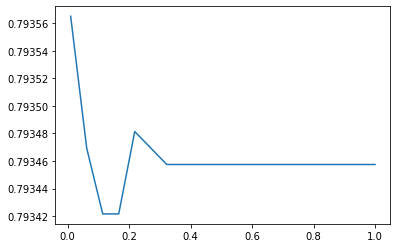

In [ ]:
c_1 = np.linspace(0.01,1,20)
 
score = []
for i in c_1: 
    lr = LR(solver='liblinear',C=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot(c_1,score)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


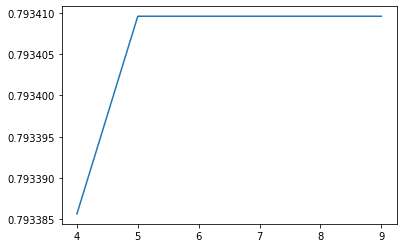

In [ ]:
lr.n_iter_#array([7], dtype=int32)
 
score = []
for i in [4,5,6,7,8,9]: 
    lr = LR(solver='liblinear',C=0.025,max_iter=i).fit(X,y)
    score.append(lr.score(vali_X,vali_y))
plt.figure()
plt.plot([4,5,6,7,8,9],score)
plt.show()

In [ ]:
!pip install scikit-plot

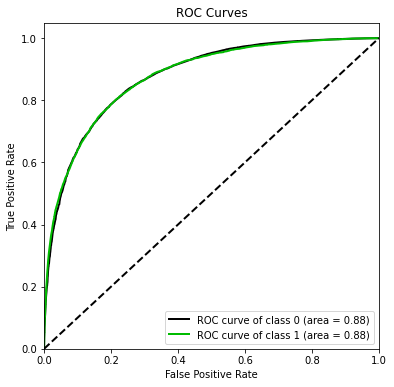

In [ ]:
import scikitplot as skplt
vali_proba_df = pd.DataFrame(lr.predict_proba(vali_X))
skplt.metrics.plot_roc(vali_y, vali_proba_df,
            plot_micro=False,figsize=(6,6),
            plot_macro=False)

$Score = A - B*log(odds)$

$odds = e^{\theta^Tx}$

In [ ]:
#通常我们需要一定的初值条件来计算A和B
#由于上面的计算公式，我们可以发现系数与特征矩阵的乘积可以轻松地得到odds
#假设条件：
#某个特定地违约几率下的预期分值
#概率加倍的情况下的分数PDO--points to double the odds
#A is called the 刻度
#B is called the 补偿
B = 20/np.log(2)
A = 600 + B*np.log(1/60)

In [ ]:
#注意我们的线性回归模型具有截距项，而截距项的值不会变，因此它会作为一个基准分来计算
base_score = A - B*lr.intercept_#lr.intercept_：截距
base_score#array([481.56390143])


array([481.66678657])

In [ ]:
#观察到coef的形式是二维ndarray的形式，因此要注意选取的方式
lr.coef_

array([[-0.42981722, -0.78797634, -0.30277969, -0.85447369, -0.93273814,
        -0.71575487, -0.69577184, -1.70403   , -0.57039726, -0.38301487]])

In [ ]:
#注意到训练数据确定之后，箱子分好之后，每一个箱子对应的woe值也就确定了
#然后根据我们的woe值，带入到模型之中，由于这是属于一个线性的模型，因此每一个项可以单独提取出来，然后再加和
#下面示例如何得到"age"的每个箱子所对应的分数

In [ ]:
score_age = woeall["age"] * (-B*lr.coef_[0][1])#lr.coef_：每一个特征建模之后得出的系数
score_age#"age"特征中每个箱对应的分数

cut
(-inf, 45.0]       -8.640041
(45.0, 46.973]    -19.943108
(46.973, 58.75]    -1.916649
(58.75, 64.0]      13.465740
(64.0, inf]        26.973735
dtype: float64

In [ ]:
#根据上面的分数，业务人员可以直接对照表进行查询即可